In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:

sns.set_theme(style="whitegrid")

In [3]:

# PART A: DATA PREPARATION

# 1. Load Datasets
print("Loading datasets...")
df_sentiment = pd.read_csv('fear_greed_index.csv')
df_trades = pd.read_csv('historical_data.csv')

# Document Rows, Columns, Missing Values, Duplicates
print("\n--- 1. Dataset Documentation ---")
print(f"Sentiment Data: {df_sentiment.shape[0]} rows, {df_sentiment.shape[1]} columns")
print(f"Trader Data: {df_trades.shape[0]} rows, {df_trades.shape[1]} columns")

print("\nMissing Values (Trader Data):\n", df_trades.isnull().sum())
print("\nDuplicates (Trader Data):", df_trades.duplicated().sum())

# Drop duplicates if any exist
df_trades.drop_duplicates(inplace=True)

# 2. Convert Timestamps & Align Datasets
print("\n--- 2. Date Processing & Alignment ---")
# Sentiment Date
df_sentiment['Date'] = pd.to_datetime(df_sentiment['date']).dt.date
# Group 'Extreme Fear' with 'Fear' and 'Extreme Greed' with 'Greed' for simpler analysis
df_sentiment['Broad_Sentiment'] = df_sentiment['classification'].replace({
    'Extreme Fear': 'Fear', 'Extreme Greed': 'Greed'
})

# Trader Date: Assuming 'Timestamp IST' format like '02-12-2024 22:50'
# We parse the date part only.
df_trades['Date'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date

# 3. Create Key Metrics
# Determine Win/Loss only on Closed PnL that isn't exactly 0 (0 usually means opening a position)
df_trades['is_trade_close'] = df_trades['Closed PnL'] != 0
df_trades['is_win'] = (df_trades['Closed PnL'] > 0).astype(int)

# Create Long/Short Indicators based on Side/Direction
df_trades['is_long'] = df_trades['Direction'].str.contains('Long|Buy', case=False, na=False).astype(int)
df_trades['is_short'] = df_trades['Direction'].str.contains('Short|Sell', case=False, na=False).astype(int)

# Daily Aggregation per Account
daily_trader_stats = df_trades.groupby(['Account', 'Date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_trades=('Account', 'count'),
    closed_trades=('is_trade_close', 'sum'),
    wins=('is_win', 'sum'),
    avg_trade_size_usd=('Size USD', 'mean'),
    total_longs=('is_long', 'sum'),
    total_shorts=('is_short', 'sum')
).reset_index()

# Calculate Win Rate (wins / closed_trades) - fill NaN with 0
daily_trader_stats['win_rate'] = (daily_trader_stats['wins'] / daily_trader_stats['closed_trades']).fillna(0)

# Merge with Sentiment Data
merged_data = pd.merge(daily_trader_stats, df_sentiment[['Date', 'Broad_Sentiment']], on='Date', how='inner')
print("Data successfully merged! Final shape:", merged_data.shape)

Loading datasets...

--- 1. Dataset Documentation ---
Sentiment Data: 2644 rows, 4 columns
Trader Data: 211224 rows, 16 columns

Missing Values (Trader Data):
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicates (Trader Data): 0

--- 2. Date Processing & Alignment ---
Data successfully merged! Final shape: (2340, 11)


/tmp/ipython-input-34320302.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fg_data, x='Broad_Sentiment', y='daily_pnl', errorbar=None, palette='coolwarm')
/tmp/ipython-input-34320302.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fg_data, x='Broad_Sentiment', y='win_rate', errorbar=None, palette='coolwarm')
/tmp/ipython-input-34320302.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fg_data, x='Broad_Sentiment', y='total_trades', errorbar=None, palette='coolwarm')


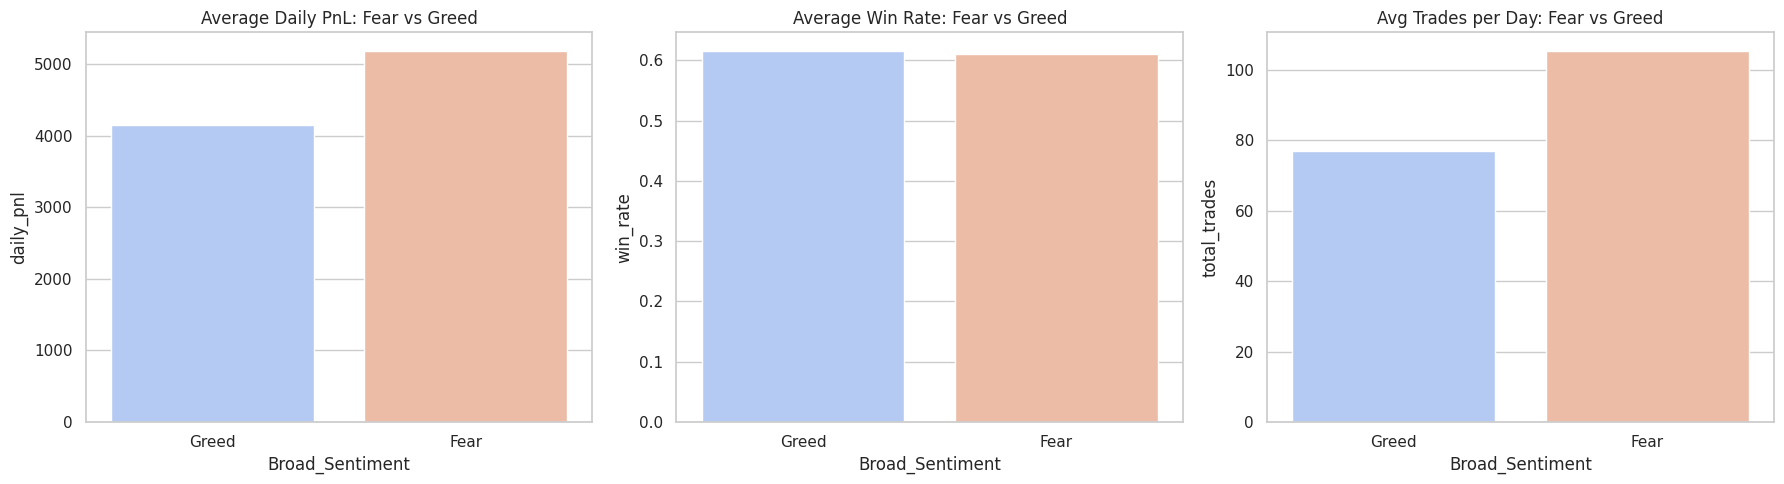

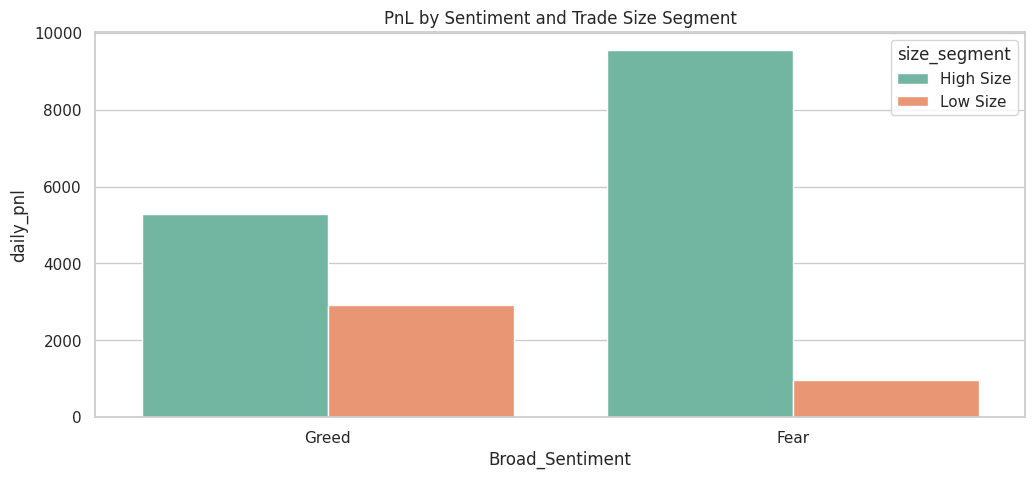

Data saved as 'cleaned_dashboard_data.csv' for Streamlit.


In [4]:

# PART B: ANALYSIS & VISUALIZATION


# Remove neutral days to specifically contrast Fear vs Greed
fg_data = merged_data[merged_data['Broad_Sentiment'].isin(['Fear', 'Greed'])]

plt.figure(figsize=(18, 5))

# Plot 1: Average Daily PnL by Sentiment
plt.subplot(1, 3, 1)
sns.barplot(data=fg_data, x='Broad_Sentiment', y='daily_pnl', errorbar=None, palette='coolwarm')
plt.title('Average Daily PnL: Fear vs Greed')

# Plot 2: Average Win Rate by Sentiment
plt.subplot(1, 3, 2)
sns.barplot(data=fg_data, x='Broad_Sentiment', y='win_rate', errorbar=None, palette='coolwarm')
plt.title('Average Win Rate: Fear vs Greed')

# Plot 3: Trade Frequency by Sentiment
plt.subplot(1, 3, 3)
sns.barplot(data=fg_data, x='Broad_Sentiment', y='total_trades', errorbar=None, palette='coolwarm')
plt.title('Avg Trades per Day: Fear vs Greed')

plt.tight_layout()
plt.show()

# --- SEGMENTATION ---
# Segment 1: Trade Size (High USD vs Low USD based on median)
median_size = merged_data['avg_trade_size_usd'].median()
merged_data['size_segment'] = np.where(merged_data['avg_trade_size_usd'] >= median_size, 'High Size', 'Low Size')

# Segment 2: Trading Frequency (Frequent vs Infrequent)
median_trades = merged_data['total_trades'].median()
merged_data['frequency_segment'] = np.where(merged_data['total_trades'] >= median_trades, 'Frequent', 'Infrequent')

# Visualize Segmentation Performance
plt.figure(figsize=(12, 5))
sns.barplot(data=merged_data[merged_data['Broad_Sentiment'].isin(['Fear', 'Greed'])],
            x='Broad_Sentiment', y='daily_pnl', hue='size_segment', palette='Set2', errorbar=None)
plt.title('PnL by Sentiment and Trade Size Segment')
plt.show()

# Save the finalized clean data for the Streamlit dashboard
merged_data.to_csv('cleaned_dashboard_data.csv', index=False)
print("Data saved as 'cleaned_dashboard_data.csv' for Streamlit.")

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

print("1. Processing Data...")
# Load data
df_sentiment = pd.read_csv('fear_greed_index.csv')
df_trades = pd.read_csv('historical_data.csv')

# Prep Dates
df_sentiment['Date'] = pd.to_datetime(df_sentiment['date']).dt.date
df_sentiment['Broad_Sentiment'] = df_sentiment['classification'].replace({'Extreme Fear': 'Fear', 'Extreme Greed': 'Greed'})
df_trades['Date'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date

# Metrics
df_trades['is_trade_close'] = df_trades['Closed PnL'] != 0
df_trades['is_win'] = (df_trades['Closed PnL'] > 0).astype(int)

daily_trader_stats = df_trades.groupby(['Account', 'Date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_trades=('Account', 'count'),
    closed_trades=('is_trade_close', 'sum'),
    wins=('is_win', 'sum'),
    avg_trade_size_usd=('Size USD', 'mean')
).reset_index()

daily_trader_stats['win_rate'] = np.where(daily_trader_stats['closed_trades'] > 0,
                                          daily_trader_stats['wins'] / daily_trader_stats['closed_trades'], 0)

merged_data = pd.merge(daily_trader_stats, df_sentiment[['Date', 'Broad_Sentiment']], on='Date', how='inner')
median_size = merged_data['avg_trade_size_usd'].median()
merged_data['size_segment'] = np.where(merged_data['avg_trade_size_usd'] >= median_size, 'High Size', 'Low Size')

# Save File 1
merged_data.to_csv('cleaned_dashboard_data.csv', index=False)
print("✅ Saved cleaned_dashboard_data.csv")


print("2. Running Clustering ML...")
lifetime_stats = merged_data.groupby('Account').agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_win_rate=('win_rate', 'mean'),
    total_trades=('total_trades', 'sum')
).fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(lifetime_stats)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
lifetime_stats['Archetype_ID'] = kmeans.fit_predict(scaled_features)
lifetime_stats['Archetype'] = lifetime_stats['Archetype_ID'].map({0: "Conservative Scalper", 1: "High-Risk Degens", 2: "Consistent Whales"})

# Save File 2
lifetime_stats.reset_index().to_csv('trader_archetypes.csv', index=False)
print("✅ Saved trader_archetypes.csv")


print("3. Training Predictive AI...")
model_df = merged_data.sort_values(by=['Account', 'Date']).copy()
model_df['Next_Day_PnL'] = model_df.groupby('Account')['daily_pnl'].shift(-1)
model_df = model_df.dropna(subset=['Next_Day_PnL']).copy()
model_df['Next_Day_Profitable'] = (model_df['Next_Day_PnL'] > 0).astype(int)

le = LabelEncoder()
model_df['Sentiment_Encoded'] = le.fit_transform(model_df['Broad_Sentiment'])

X = model_df[['total_trades', 'daily_pnl', 'win_rate', 'Sentiment_Encoded']]
y = model_df['Next_Day_Profitable']

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X, y)

# Save File 3
joblib.dump(clf, 'profit_predictor_model.pkl')
print("✅ Saved profit_predictor_model.pkl")

1. Processing Data...
✅ Saved cleaned_dashboard_data.csv
2. Running Clustering ML...
✅ Saved trader_archetypes.csv
3. Training Predictive AI...
✅ Saved profit_predictor_model.pkl
